# Setup

set working directory to guitarist-net and add to path

In [4]:
%cd /content/drive/Othercomputers/My MacBook Pro/guitarist-net

/content/drive/Othercomputers/My MacBook Pro/guitarist-net


install requirements

In [5]:
!pip install -r requirements.txt &> /dev/null

imports

In [60]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import ui
from plot_listen.listen import play
from plot_listen.plot import plot, plot_single_string_item
from save_load import load_weights_from_file
from util import torch_to_numpy
from globals import *
from data.guitarset_loader import GuitarSetLoader
from ddsp.ddsp_mono_synth import DDSPMonoSynth
from torch.utils.data import DataLoader
from data.single_string_dataset import SingleStringDataset
import scipy.io.wavfile

# Load Trained Model

create model

In [7]:
synth = DDSPMonoSynth()

load weights, move to GPU, set to eval mode

In [178]:
synth.load_state_dict(load_weights_from_file())
synth = synth.to(DEVICE)
synth.eval();

Type a number to select an option:
	0)	2022-07-08 08:08PM DDSP Mono Synth : training test
	1)	2022-07-09 01:40PM DDSP Mono Synth : load model and continue training
	2)	2022-07-09 11:45PM DDSP Mono Synth : resume training (third time)
	3)	2022-07-10 10:44AM DDSP Mono Synth : train (4th time)
	4)	2022-07-19 04:05PM DDSP Mono Synth Improved : synth_improvement
	5)	2022-07-19 06:56PM DDSP Mono Synth : train with loudness centered and 32 osc + 32 filter coeffs
	6)	2022-07-20 10:48AM DDSP Mono Synth : train low E
	7)	2022-07-20 12:24PM DDSP Mono Synth Improved : improve 32 param synth - e string
	8)	2022-07-20 07:03PM DDSP Mono Synth : train with lr scheduler
	9)	2022-07-22 11:34AM DDSP Mono Synth : train low E for a while
	10)	2022-07-25 06:42PM DDSP Mono Synth : train with Leaky ReLU
	11)	2022-07-26 04:41PM DDSP Mono Synth : try training with test dataset (one guitarist)
	12)	2022-07-27 06:09PM DDSP Mono Synth : folder deleting, harmonic + noise saving
	13)	2022-07-27 06:12PM DDSP Mono Syn

# Load Track Data

In [179]:
loader = GuitarSetLoader()
track_id = ui.list_selection_menu(loader.guitarset.track_ids)
track_data = loader.get_6_string_data_from_track_unchunked(track_id)

Type a number to select an option:
	0)	00_BN1-129-Eb_comp
	1)	00_BN1-129-Eb_solo
	2)	00_BN1-147-Gb_comp
	3)	00_BN1-147-Gb_solo
	4)	00_BN2-131-B_comp
	5)	00_BN2-131-B_solo
	6)	00_BN2-166-Ab_comp
	7)	00_BN2-166-Ab_solo
	8)	00_BN3-119-G_comp
	9)	00_BN3-119-G_solo
	10)	00_BN3-154-E_comp
	11)	00_BN3-154-E_solo
	12)	00_Funk1-114-Ab_comp
	13)	00_Funk1-114-Ab_solo
	14)	00_Funk1-97-C_comp
	15)	00_Funk1-97-C_solo
	16)	00_Funk2-108-Eb_comp
	17)	00_Funk2-108-Eb_solo
	18)	00_Funk2-119-G_comp
	19)	00_Funk2-119-G_solo
	20)	00_Funk3-112-C#_comp
	21)	00_Funk3-112-C#_solo
	22)	00_Funk3-98-A_comp
	23)	00_Funk3-98-A_solo
	24)	00_Jazz1-130-D_comp
	25)	00_Jazz1-130-D_solo
	26)	00_Jazz1-200-B_comp
	27)	00_Jazz1-200-B_solo
	28)	00_Jazz2-110-Bb_comp
	29)	00_Jazz2-110-Bb_solo
	30)	00_Jazz2-187-F#_comp
	31)	00_Jazz2-187-F#_solo
	32)	00_Jazz3-137-Eb_comp
	33)	00_Jazz3-137-Eb_solo
	34)	00_Jazz3-150-C_comp
	35)	00_Jazz3-150-C_solo
	36)	00_Rock1-130-A_comp
	37)	00_Rock1-130-A_solo
	38)	00_Rock1-90-C#_comp
	39)	00_Ro

# Create Input List

In [180]:
string_let = "D"
input_keys = [f"{string_let}_f0", f"{string_let}_loudness"]
inputs = [torch.tensor(track_data[k], dtype=DEFAULT_TORCH_DTYPE).to(DEVICE).unsqueeze(0) for k in input_keys]

# scale loudness according to mean and std of single string datasets
ssd = SingleStringDataset(name=f"train_player-not00_{string_let}-string_1.0s_crepe.npz") # load loudness stats to scale - from train data
# ssd = SingleStringDataset(name=f"test_player-00_{string_let}-string_1.0s_crepe.npz") # load loudness stats to scale - from test data
inputs[1] = (inputs[1] - ssd.loudness_stats['mean']) / ssd.loudness_stats['std']


In [181]:
print(torch.mean(inputs[1]))

tensor(-0.5973, device='cuda:0')


# Feed F0s and Loudnesses into Synth Model

In [182]:
output = synth(*inputs)

# Examine output

In [183]:
play(output['reverb_audio'][0])

In [184]:
play(track_data[f'{string_let}_audio'])

# Save Off Audios

In [185]:
synth_audio = output['reverb_audio'][0].detach().cpu().numpy()
target_audio = track_data[f'{string_let}_audio']

# crop to first dur seconds
dur = 12
synth_audio = synth_audio[:(dur*SR)]
target_audio = target_audio[:(dur*SR)]

In [186]:
save_path = "/content/drive/MyDrive/Research/Thesis Proposal/audio examples/"

scipy.io.wavfile.write(f"{save_path}DDSP Mono Synth - {string_let} string example", SR, synth_audio)
scipy.io.wavfile.write(f"{save_path}DDSP Target - {string_let} string example", SR, target_audio)

# Generate Spectrograms

Target

[Text(0.5, 1.0, 'Target Audio')]

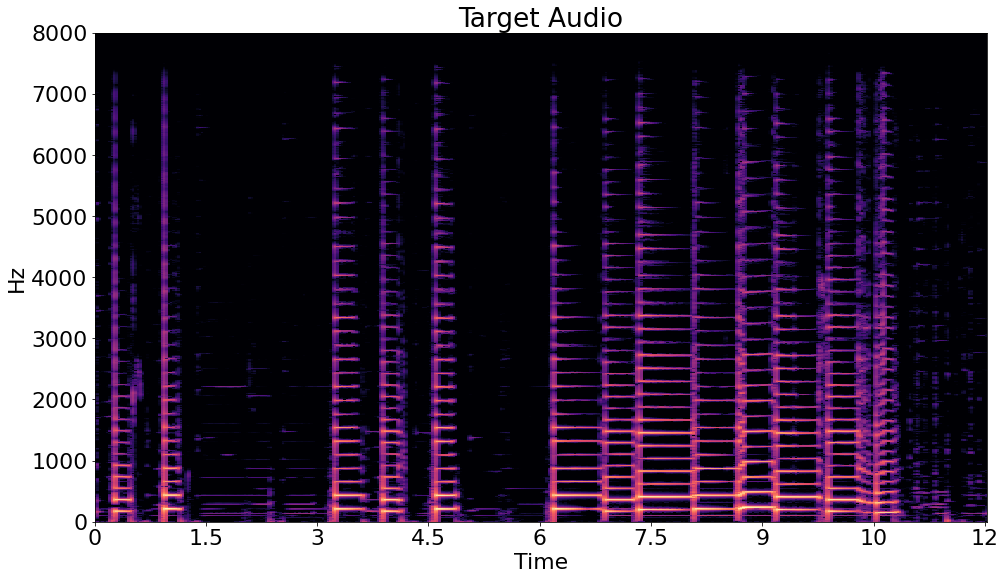

In [187]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
target_spec = librosa.amplitude_to_db(np.abs(librosa.stft(target_audio)), ref=np.max)

fig, ax = plt.subplots(figsize = (16,9))
img = librosa.display.specshow(target_spec, x_axis='time', y_axis='linear', ax=ax, sr=SR)
ax.set(title='Target Audio')





Synth

[Text(0.5, 1.0, 'Synth Audio')]

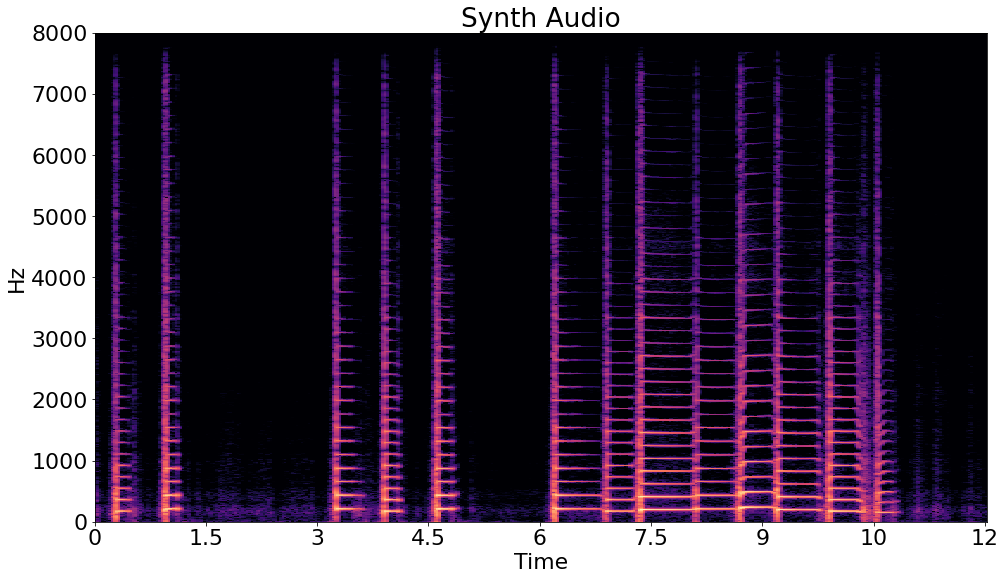

In [188]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

synth_spec = librosa.amplitude_to_db(np.abs(librosa.stft(synth_audio)), ref=np.max)

fig, ax = plt.subplots(figsize = (16,9))
img = librosa.display.specshow(synth_spec, x_axis='time', y_axis='linear', ax=ax, sr=SR)
ax.set(title='Synth Audio')